<a href="https://colab.research.google.com/github/Foco22/Project/blob/master/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalar PySpark y las librerias

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.0.1-bin-hadoop2.7"

In [15]:
!pip -q install numpy matplotlib

import findspark
findspark.init()

import os
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import Row
from pyspark.sql import SparkSession
import seaborn as sns

spark = SparkSession.builder.appName("Bank").getOrCreate()

## Carga de Datos (Segmentacion de Clientes)

In [4]:
from google.colab import files
uploaded = files.upload()

Saving Users1.csv to Users1.csv


In [310]:
clients = spark.read.csv('Users1.csv', header=True, sep=';')

In [311]:
clients.show(10)

+-----+----------------+-------------+----------------------+---------------+------+----+--------------------+
|State|      Profession|Profesion Key|Agree terms conditions|Card Mastercard|Source|Edad|         Region Pais|
+-----+----------------+-------------+----------------------+---------------+------+----+--------------------+
|    4|     Horticultor|            1|             VERDADERO|          FALSO|  null|  26|Libertador Genera...|
|    4|      estudiante|            2|             VERDADERO|      VERDADERO|  null|  18|Regi�n Metropolit...|
|    4|   SIN ACTIVIDAD|            3|             VERDADERO|          FALSO|  null|  30|Regi�n Metropolit...|
|    4|      estudiante|            2|             VERDADERO|          FALSO|  null|  25|             Atacama|
|    4|        empleado|            4|             VERDADERO|          FALSO|  null|  57|        La Araucan�a|
|    4|        soldador|            5|             VERDADERO|          FALSO|  null|  29|Regi�n Metropolit...|
|

## Analisis Descriptivo por Variable


In [7]:
from pyspark.sql.functions import isnan, when, count, col

In [10]:
print("Cantidad de Registros del Dataset {}".format(clients.count()))

Cantidad de Registros del Dataset 28880


In [11]:
clients.select([count(when(col(c).isNull(), c)).alias(c) for c in 
           clients.columns]).toPandas().T

,0
State,0
Profession,0
Profesion Key,0
Agree terms conditions,0
Card Mastercard,0
Source,27042
Edad,0
Region Pais,0


**La mayoria de los datos de Source son vacios, por lo que, eliminare del analisis esa columna, ya que la gran mayoria de los datos estqan perdidos.



In [12]:
clients.drop("Source") \
.printSchema()

root
 |-- State: string (nullable = true)
 |-- Profession: string (nullable = true)
 |-- Profesion Key: string (nullable = true)
 |-- Agree terms conditions: string (nullable = true)
 |-- Card Mastercard: string (nullable = true)
 |-- Edad: string (nullable = true)
 |-- Region Pais: string (nullable = true)



In [312]:
drop_list = ['Source']

clients = clients.select([column for column in clients.columns if column not in drop_list])

clients.show(10)

+-----+----------------+-------------+----------------------+---------------+----+--------------------+
|State|      Profession|Profesion Key|Agree terms conditions|Card Mastercard|Edad|         Region Pais|
+-----+----------------+-------------+----------------------+---------------+----+--------------------+
|    4|     Horticultor|            1|             VERDADERO|          FALSO|  26|Libertador Genera...|
|    4|      estudiante|            2|             VERDADERO|      VERDADERO|  18|Regi�n Metropolit...|
|    4|   SIN ACTIVIDAD|            3|             VERDADERO|          FALSO|  30|Regi�n Metropolit...|
|    4|      estudiante|            2|             VERDADERO|          FALSO|  25|             Atacama|
|    4|        empleado|            4|             VERDADERO|          FALSO|  57|        La Araucan�a|
|    4|        soldador|            5|             VERDADERO|          FALSO|  29|Regi�n Metropolit...|
|    4|empleado publico|            6|             VERDADERO|   

**State**



Text(0, 0.5, 'Cantidad')

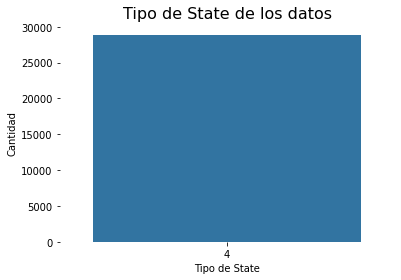

In [16]:
state = clients.groupBy('State').count().orderBy('count').toPandas()
sns.barplot(data = state, x ='State', y ='count')
plt.title('Tipo de State de los datos', fontsize = 16)
sns.despine(left=True, bottom=True)
plt.xlabel('Tipo de State')
plt.ylabel('Cantidad')

In [313]:
drop_list = ['State']

clients = clients.select([column for column in clients.columns if column not in drop_list])

clients.show(10)

+----------------+-------------+----------------------+---------------+----+--------------------+
|      Profession|Profesion Key|Agree terms conditions|Card Mastercard|Edad|         Region Pais|
+----------------+-------------+----------------------+---------------+----+--------------------+
|     Horticultor|            1|             VERDADERO|          FALSO|  26|Libertador Genera...|
|      estudiante|            2|             VERDADERO|      VERDADERO|  18|Regi�n Metropolit...|
|   SIN ACTIVIDAD|            3|             VERDADERO|          FALSO|  30|Regi�n Metropolit...|
|      estudiante|            2|             VERDADERO|          FALSO|  25|             Atacama|
|        empleado|            4|             VERDADERO|          FALSO|  57|        La Araucan�a|
|        soldador|            5|             VERDADERO|          FALSO|  29|Regi�n Metropolit...|
|empleado publico|            6|             VERDADERO|          FALSO|  34|          Valpara�so|
|      almacenera|  

**Profession/Profesion Key**


In [314]:
from pyspark.sql.functions import lower

clients = clients.withColumn('Profession_lower', lower(col('Profession')))
clients.show(10)

+----------------+-------------+----------------------+---------------+----+--------------------+----------------+
|      Profession|Profesion Key|Agree terms conditions|Card Mastercard|Edad|         Region Pais|Profession_lower|
+----------------+-------------+----------------------+---------------+----+--------------------+----------------+
|     Horticultor|            1|             VERDADERO|          FALSO|  26|Libertador Genera...|     horticultor|
|      estudiante|            2|             VERDADERO|      VERDADERO|  18|Regi�n Metropolit...|      estudiante|
|   SIN ACTIVIDAD|            3|             VERDADERO|          FALSO|  30|Regi�n Metropolit...|   sin actividad|
|      estudiante|            2|             VERDADERO|          FALSO|  25|             Atacama|      estudiante|
|        empleado|            4|             VERDADERO|          FALSO|  57|        La Araucan�a|        empleado|
|        soldador|            5|             VERDADERO|          FALSO|  29|Regi

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000.]),
 <a list of 8 Text major ticklabel objects>)

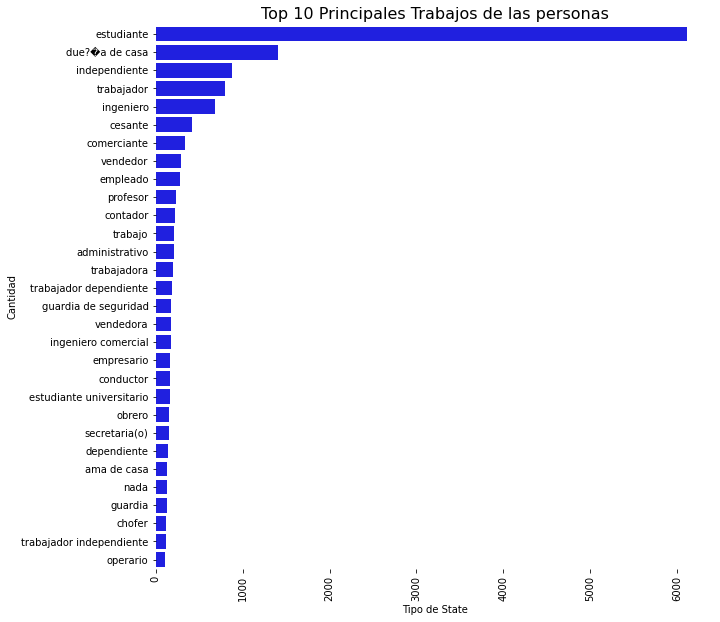

In [19]:
profesional = clients.groupBy('Profession_lower').count().orderBy('count', ascending = False)
profesional = profesional.toPandas().head(30)
plt.figure(figsize = (10,10))
sns.barplot(data = profesional, y ='Profession_lower', x ='count', color = 'b')
plt.title('Top 10 Principales Trabajos de las personas', fontsize = 16)
sns.despine(left=True, bottom=True)
plt.xlabel('Tipo de State')
plt.ylabel('Cantidad')
plt.xticks(rotation=90)

Ahora, vamos a ser un analisis de los estudiante, posiblemente hay muchos registros que son estudiantes, pero que no fueron escritos correctamente. Veremos como podemos obtener estos registros


In [315]:
#Grupo 1: Estudiantes
estudiantes = clients.toPandas()
estudiantes = np.unique(list(estudiantes[estudiantes['Profession_lower'].str.match('^estu.*')== True]['Profession_lower']))

#Grupo 2: Asesora del Hogar

dueña_casa = ['due?�a de casa' ,'ama de casa', 'due?�a casa', 'casa','nana de la casa', 'nana','nano','ama dd casa',
             'duena se casa','duesa de casa','due?�o de ogar', 'due?�a de caaa','due?�a de cass','due?�o de casa',
             'ama de casa y trabajadora', 'due?�a de casa cuidando a mi beb?�', 'hogar', 'casa']

#Grupo 3: Desempleo

desempleo  = ['sin actividad', 'sin empleo', 'sin enpleo','sin ocupaci??n',
       'sin ocupacion', 'sin ocupaciones', 'sin oficio', 'sin ofu',
       'sin profecion', 'sin profesion', 'sin trabaj??', 'sin trabajo',
       'sin trabajo actualmente', 'sin trabajo ayuden', 'sin vocacion',
       'desempl', 'desempleada', 'desempleado', 'desempleo',
       'desenpkeado', 'desenpleada', 'desenpleado','cesante']

#Grupo 4: informacion erronea.

sin_informacion = ['sin informaci??n','nada', 'nada','nada de momento', 'nada por el momento', 'nadaa'
                  'no aplica', 'mm piping', '?±i?±os', 'dkdjjffn', 'uy curiosos', 'nnnnnnnnnnnnn' , 'trabajo']

In [316]:
def profesional(x):
   if x in estudiantes:
     return 'Estudiantes'
   elif x in dueña_casa:
      return 'Dueña de Casa'
   elif x in desempleo:
      return 'Desempleo'
   elif x in sin_informacion:
      return 'Sin_informacion'
   else:
      return 'Trabajando'

In [317]:


from pyspark.sql.functions import udf
from pyspark.sql.types import *
udfValueToCategory = udf(profesional, StringType())
clients = clients.withColumn("Categoria", udfValueToCategory("Profession_lower"))
clients.show()


+--------------------+-------------+----------------------+---------------+----+--------------------+--------------------+-------------+
|          Profession|Profesion Key|Agree terms conditions|Card Mastercard|Edad|         Region Pais|    Profession_lower|    Categoria|
+--------------------+-------------+----------------------+---------------+----+--------------------+--------------------+-------------+
|         Horticultor|            1|             VERDADERO|          FALSO|  26|Libertador Genera...|         horticultor|   Trabajando|
|          estudiante|            2|             VERDADERO|      VERDADERO|  18|Regi�n Metropolit...|          estudiante|  Estudiantes|
|       SIN ACTIVIDAD|            3|             VERDADERO|          FALSO|  30|Regi�n Metropolit...|       sin actividad|    Desempleo|
|          estudiante|            2|             VERDADERO|          FALSO|  25|             Atacama|          estudiante|  Estudiantes|
|            empleado|            4|     

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

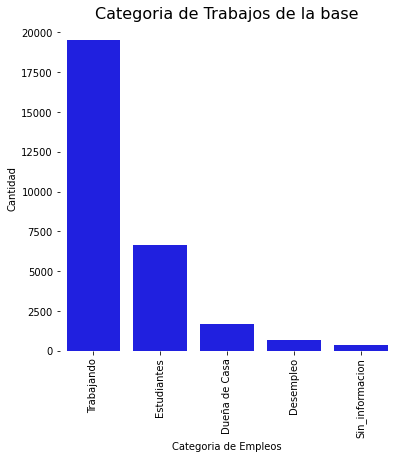

In [318]:
profesional = clients.groupBy('Categoria').count().orderBy('count', ascending = False)
profesional = profesional.toPandas().head(30)
plt.figure(figsize = (6,6))
sns.barplot(data = profesional, x ='Categoria', y ='count', color = 'b')
plt.title('Categoria de Trabajos de la base', fontsize = 16)
sns.despine(left=True, bottom=True)
plt.xlabel('Categoria de Empleos')
plt.ylabel('Cantidad')
plt.xticks(rotation=90)

In [319]:
drop_list = ['Profession','Profesion Key', 'Profession_lower']

clients = clients.select([column for column in clients.columns if column not in drop_list])


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

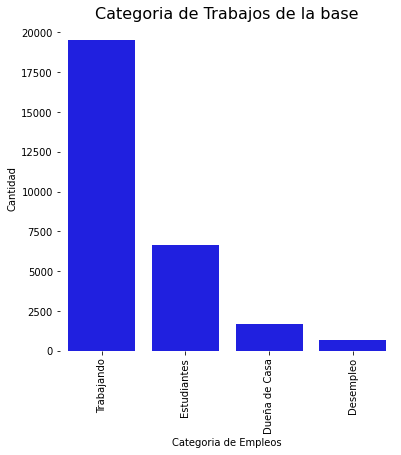

In [320]:
clients = clients.filter("Categoria != 'Sin_informacion' ")

profesional = clients.groupBy('Categoria').count().orderBy('count', ascending = False)
profesional = profesional.toPandas().head(30)
plt.figure(figsize = (6,6))
sns.barplot(data = profesional, x ='Categoria', y ='count', color = 'b')
plt.title('Categoria de Trabajos de la base', fontsize = 16)
sns.despine(left=True, bottom=True)
plt.xlabel('Categoria de Empleos')
plt.ylabel('Cantidad')
plt.xticks(rotation=90)

**Agree Terms Conditions**


(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000.]),
 <a list of 7 Text major ticklabel objects>)

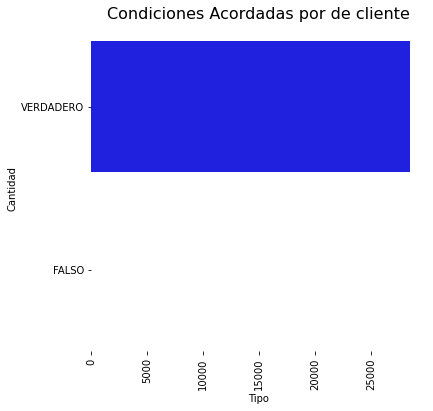

In [321]:
profesional = clients.groupBy('Agree terms conditions').count().orderBy('count', ascending = False)
profesional = profesional.toPandas().head(30)
plt.figure(figsize = (6,6))
sns.barplot(data = profesional, y ='Agree terms conditions', x ='count', color = 'b')
plt.title('Condiciones Acordadas por de cliente', fontsize = 16)
sns.despine(left=True, bottom=True)
plt.xlabel('Tipo')
plt.ylabel('Cantidad')
plt.xticks(rotation=90)

In [322]:
clients = clients.filter("'Agree terms conditions' != 'FALSO' ")
clients.show(10)

+----------------------+---------------+----+--------------------+-------------+
|Agree terms conditions|Card Mastercard|Edad|         Region Pais|    Categoria|
+----------------------+---------------+----+--------------------+-------------+
|             VERDADERO|          FALSO|  26|Libertador Genera...|   Trabajando|
|             VERDADERO|      VERDADERO|  18|Regi�n Metropolit...|  Estudiantes|
|             VERDADERO|          FALSO|  30|Regi�n Metropolit...|    Desempleo|
|             VERDADERO|          FALSO|  25|             Atacama|  Estudiantes|
|             VERDADERO|          FALSO|  57|        La Araucan�a|   Trabajando|
|             VERDADERO|          FALSO|  29|Regi�n Metropolit...|   Trabajando|
|             VERDADERO|          FALSO|  34|          Valpara�so|   Trabajando|
|             VERDADERO|          FALSO|  60|Regi�n Metropolit...|   Trabajando|
|             VERDADERO|          FALSO|  30|            Tarapac�|   Trabajando|
|             VERDADERO|    

In [323]:
drop_list = ['Agree terms conditions']

clients = clients.select([column for column in clients.columns if column not in drop_list])

**Card Mastercard**


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

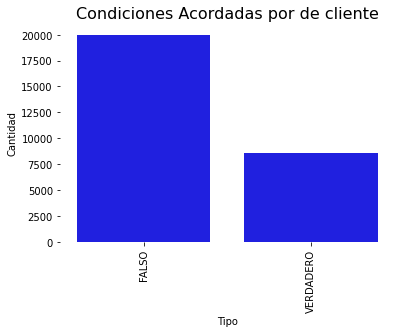

In [324]:
profesional = clients.groupBy('Card Mastercard').count().orderBy('count', ascending = False)
profesional = profesional.toPandas().head(30)
plt.figure(figsize = (6,4))
sns.barplot(data = profesional, x ='Card Mastercard', y ='count', color = 'b')
plt.title('Condiciones Acordadas por de cliente', fontsize = 16)
sns.despine(left=True, bottom=True)
plt.xlabel('Tipo')
plt.ylabel('Cantidad')
plt.xticks(rotation=90)

**Edad**


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


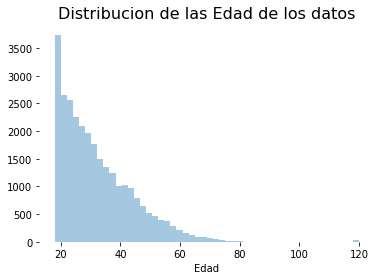

In [325]:
edad = clients.toPandas()
edad['Edad'] = edad['Edad'].apply(lambda x: int(x))
sns.distplot(edad['Edad'], kde = False)
plt.title('Distribucion de las Edad de los datos', fontsize = 16)
sns.despine(left=True, bottom=True)

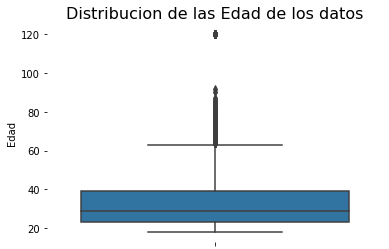

In [326]:
sns.boxplot(data = edad, y ='Edad' )
plt.title('Distribucion de las Edad de los datos', fontsize = 16)
sns.despine(left=True, bottom=True)

In [32]:
print('Maxima Edad del dataset es :{}'.format(edad['Edad'].max()))

Maxima Edad del dataset es :120


Filtrar los datos, para sacar el dato que tiene 120 años, ya que puede afectar a los analisis posteriores.


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


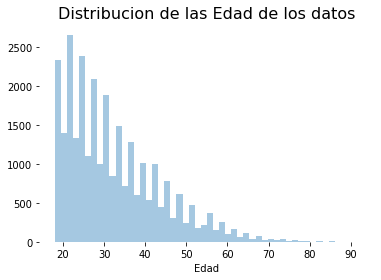

In [327]:
clients = clients.filter(" Edad != '120' ")
edad = clients.toPandas()
edad['Edad'] = edad['Edad'].apply(lambda x: int(x))
sns.distplot(edad['Edad'], kde = False)
plt.title('Distribucion de las Edad de los datos', fontsize = 16)
sns.despine(left=True, bottom=True)

**Region Pais**



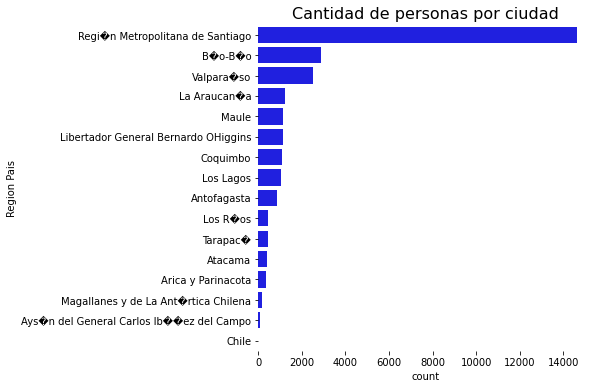

In [328]:
region = clients.groupBy('Region Pais').count().orderBy('count', ascending = False)
region = region.toPandas()

plt.figure(figsize = (6,6))
sns.barplot( data = region, y ='Region Pais', x ='count', color = 'b')
plt.title('Cantidad de personas por ciudad', fontsize = 16)
sns.despine(left=True, bottom=True)

In [342]:
clients = clients.filter(col("Region Pais") != "Chile") 

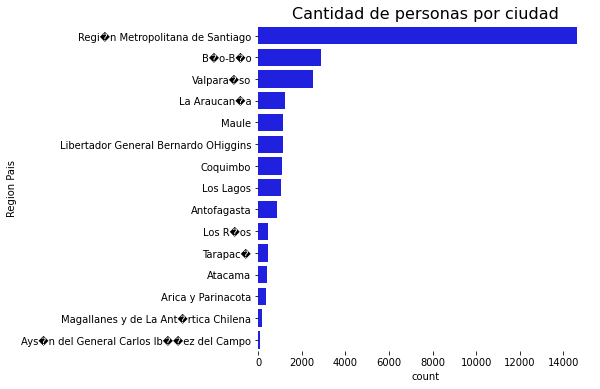

In [343]:
region = clients.groupBy('Region Pais').count().orderBy('count', ascending = False)
region = region.toPandas()

plt.figure(figsize = (6,6))
sns.barplot( data = region, y ='Region Pais', x ='count', color = 'b')
plt.title('Cantidad de personas por ciudad', fontsize = 16)
sns.despine(left=True, bottom=True)

In [344]:
def region(x):
   if  x == 'Regi�n Metropolitana de Santiago':
       return 'Santiago'
   else:
       return 'No Santiago'

udfValueToCategory = udf(region, StringType())
clients = clients.withColumn("Region Pais", udfValueToCategory("Region Pais"))
clients.show()

+---------------+----+-----------+-------------+
|Card Mastercard|Edad|Region Pais|    Categoria|
+---------------+----+-----------+-------------+
|          FALSO|  26|No Santiago|   Trabajando|
|      VERDADERO|  18|   Santiago|  Estudiantes|
|          FALSO|  30|   Santiago|    Desempleo|
|          FALSO|  25|No Santiago|  Estudiantes|
|          FALSO|  57|No Santiago|   Trabajando|
|          FALSO|  29|   Santiago|   Trabajando|
|          FALSO|  34|No Santiago|   Trabajando|
|          FALSO|  60|   Santiago|   Trabajando|
|          FALSO|  30|No Santiago|   Trabajando|
|          FALSO|  32|No Santiago|Dueña de Casa|
|          FALSO|  25|No Santiago|   Trabajando|
|          FALSO|  25|   Santiago|   Trabajando|
|      VERDADERO|  19|No Santiago|  Estudiantes|
|      VERDADERO|  25|   Santiago|  Estudiantes|
|          FALSO|  36|   Santiago|   Trabajando|
|          FALSO|  22|   Santiago|  Estudiantes|
|      VERDADERO|  34|No Santiago|   Trabajando|
|          FALSO|  1

## Transformation/Reprocesamiento de Variables


In [345]:
clients_prepo = clients


In [346]:
from pyspark.sql.types import IntegerType
clients_prepo = clients_prepo.withColumn("Edad", clients_prepo["Edad"].cast(IntegerType()))
clients_prepo

DataFrame[Card Mastercard: string, Edad: int, Region Pais: string, Categoria: string]

In [347]:
cat_cols = ['Card Mastercard','Region Pais','Categoria']
num_cols = ['Edad']

indexers = [StringIndexer(inputCol = c, outputCol="{0}_indexed".format(c)) for c in cat_cols]

encoders = [StringIndexer(inputCol = indexer.getOutputCol(), outputCol = "{0}_encoded".format(indexer.getOutputCol())) 
for indexer in indexers]

assemblerCat = VectorAssembler(inputCols = [encoder.getOutputCol() for encoder in encoders], outputCol = "cat", handleInvalid="skip")

pipelineCat = Pipeline(stages = indexers + encoders + [assemblerCat])

clients_prepo = pipelineCat.fit(clients_prepo).transform(clients_prepo)

assemblerNum = VectorAssembler(inputCols = num_cols, outputCol = "num", handleInvalid="skip")

pipelineNum = Pipeline(stages = [assemblerNum])
clients_prepo = pipelineNum.fit(clients_prepo).transform(clients_prepo)

assembler = VectorAssembler(inputCols = ["cat", "num"], outputCol = "features", handleInvalid="skip").setHandleInvalid("keep")

pipeline = Pipeline(stages = [assembler])
clients_prepo = pipeline.fit(clients_prepo).transform(clients_prepo)

In [211]:
clients_prepo.show(10)


+---------------+----+-----------+-------------+-----------------------+-------------------+-----------------+-------------------------------+---------------------------+-------------------------+-------------+------+------------------+
|Card Mastercard|Edad|Region Pais|    Categoria|Card Mastercard_indexed|Region Pais_indexed|Categoria_indexed|Card Mastercard_indexed_encoded|Region Pais_indexed_encoded|Categoria_indexed_encoded|          cat|   num|          features|
+---------------+----+-----------+-------------+-----------------------+-------------------+-----------------+-------------------------------+---------------------------+-------------------------+-------------+------+------------------+
|          FALSO|  26|No Santiago|   Trabajando|                    0.0|                1.0|              0.0|                            0.0|                        1.0|                      0.0|[0.0,1.0,0.0]|[26.0]|[0.0,1.0,0.0,26.0]|
|      VERDADERO|  18|   Santiago|  Estudiantes|    

## Modelo K- Means


In [348]:
clients_prepo.count()

28485

In [349]:
clients_prepo = clients_prepo.limit(28491)

In [350]:
from pyspark.ml.clustering import KMeans

K = 3

algorithm = KMeans(k=K)
model = algorithm.fit(clients_prepo)

In [351]:
clustered = model.transform(clients_prepo)

In [352]:
clustered.show(10)

+---------------+----+-----------+-------------+-----------------------+-------------------+-----------------+-------------------------------+---------------------------+-------------------------+-------------+------+------------------+----------+
|Card Mastercard|Edad|Region Pais|    Categoria|Card Mastercard_indexed|Region Pais_indexed|Categoria_indexed|Card Mastercard_indexed_encoded|Region Pais_indexed_encoded|Categoria_indexed_encoded|          cat|   num|          features|prediction|
+---------------+----+-----------+-------------+-----------------------+-------------------+-----------------+-------------------------------+---------------------------+-------------------------+-------------+------+------------------+----------+
|          FALSO|  26|No Santiago|   Trabajando|                    0.0|                1.0|              0.0|                            0.0|                        1.0|                      0.0|[0.0,1.0,0.0]|[26.0]|[0.0,1.0,0.0,26.0]|         0|
|      V

## Curva Elbow

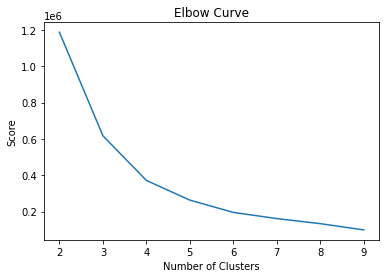

<Figure size 432x288 with 0 Axes>

In [353]:
import pandas as pd 

cost = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(clients_prepo)
    cost[k] = model.summary.trainingCost

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()
sns.despine(left=True, bottom=True)

Se puede desprender que el optimo numero de cluster es 4, ya que el error de la distancia de los puntos a los centroides se estabiliza en esa cantidad de clusters

##Optimo y Visualizacion


In [362]:
#numero de cluster optimo 

K = 4

algorithm = KMeans(k=K)
model = algorithm.fit(clients_prepo)

clustered = model.transform(clients_prepo)

clustered.show(10)

+---------------+----+-----------+-------------+-----------------------+-------------------+-----------------+-------------------------------+---------------------------+-------------------------+-------------+------+------------------+----------+
|Card Mastercard|Edad|Region Pais|    Categoria|Card Mastercard_indexed|Region Pais_indexed|Categoria_indexed|Card Mastercard_indexed_encoded|Region Pais_indexed_encoded|Categoria_indexed_encoded|          cat|   num|          features|prediction|
+---------------+----+-----------+-------------+-----------------------+-------------------+-----------------+-------------------------------+---------------------------+-------------------------+-------------+------+------------------+----------+
|          FALSO|  26|No Santiago|   Trabajando|                    0.0|                1.0|              0.0|                            0.0|                        1.0|                      0.0|[0.0,1.0,0.0]|[26.0]|[0.0,1.0,0.0,26.0]|         0|
|      V

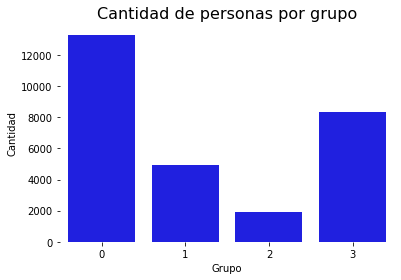

In [363]:
clients_optimo = clustered.toPandas()

grupo = clients_optimo['prediction'].value_counts().reset_index()
sns.barplot(data = grupo, x = 'index' , y = 'prediction', color = 'b' )
plt.title('Cantidad de personas por grupo', fontsize = 16)
plt.xlabel('Grupo')
plt.ylabel('Cantidad')
sns.despine(left=True, bottom=True)

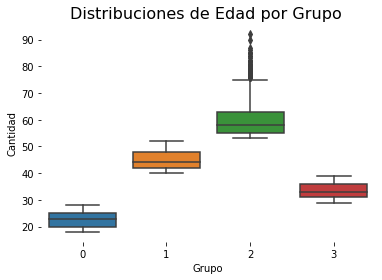

In [364]:
sns.boxplot( data = clients_optimo, y = 'Edad', x = 'prediction')
plt.title('Distribuciones de Edad por Grupo ', fontsize = 16)
plt.xlabel('Grupo')
plt.ylabel('Cantidad')
sns.despine(left=True, bottom=True)

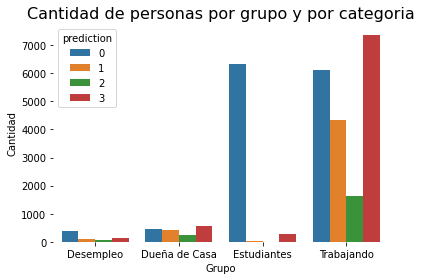

In [365]:
categoria = clients_optimo.groupby(['prediction','Categoria']).count()['Card Mastercard'].reset_index()

sns.barplot( data = categoria, hue = 'prediction', y = 'Card Mastercard', x = 'Categoria')

plt.title('Cantidad de personas por grupo y por categoria', fontsize = 16)
plt.xlabel('Grupo')
plt.ylabel('Cantidad')
sns.despine(left=True, bottom=True)

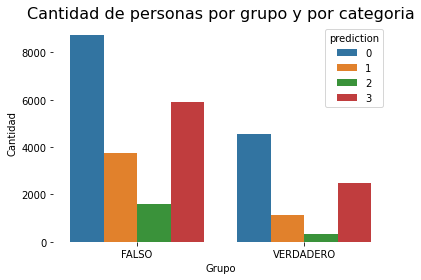

In [366]:
master = clients_optimo.groupby(['Card Mastercard','prediction']).count()['Categoria'].reset_index()

sns.barplot( data = master, x = 'Card Mastercard', hue = 'prediction', y = 'Categoria')

plt.title('Cantidad de personas por grupo y por categoria', fontsize = 16)
plt.xlabel('Grupo')
plt.ylabel('Cantidad')
sns.despine(left=True, bottom=True)


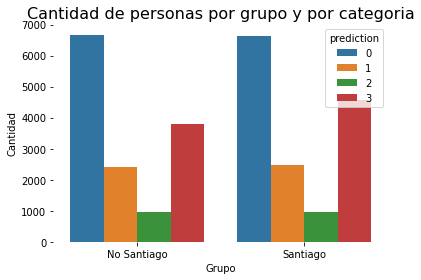

In [367]:
region = clients_optimo.groupby(['Region Pais','prediction']).count()['Categoria'].reset_index()

sns.barplot( data = region, x = 'Region Pais', hue = 'prediction', y = 'Categoria')

plt.title('Cantidad de personas por grupo y por categoria', fontsize = 16)
plt.xlabel('Grupo')
plt.ylabel('Cantidad')
sns.despine(left=True, bottom=True)
